In [1]:
using Catlab
using Catlab.Graphics
using CombinatorialSpaces
using Decapodes
using DiagrammaticEquations, DiagrammaticEquations.Deca
using Distributions
using MLStyle
using OrdinaryDiffEq
using LinearAlgebra
using ComponentArrays
using CairoMakie
using GeometryBasics: Point2, Point3
Point2D = Point2{Float64}
Point3D = Point3{Float64}

GeometryBasics.Point{3, Float64}

Load in our Decapodes models

In [2]:
using Decapodes.Canon.Oncology

Let's examine our models. Here's the tumor invasion model with the logistic and Gompertz growth models.

In [3]:
@doc invasion

**TumorInvasion**

[Source](https://en.wikipedia.org/wiki/Cancer_cell#Causes)

Eq. 35 from Yi et al.   A Review of Mathematical Models for Tumor Dynamics and Treatment Resistance   Evolution of Solid Tumors

**Model** 

```
(C, fC)::Form0
              
(Dif, Kd, Cmax)::Constant
              
∂ₜ(C) == (Dif * Δ(C) + fC) - Kd * C
```


In [4]:
@doc logistic

**Logistic**

[Source](https://en.wikipedia.org/wiki/Logistic_function)

Eq. 5 from Yi et al.   A Review of Mathematical Models for Tumor Dynamics and Treatment Resistance   Evolution of Solid Tumors

**Model** 

```
(C, fC)::Form0
              
Cmax::Constant
              
fC == C * (1 - C / Cmax)
```


In [5]:
@doc gompertz

**Gompertz**

[Source](https://en.wikipedia.org/wiki/Gompertz_function)

Eq. 6 from Yi et al.   A Review of Mathematical Models for Tumor Dynamics and Treatment Resistance   Evolution of Solid Tumors

**Model** 

```
(C, fC)::Form0
              
Cmax::Constant
              
fC == C * ln(Cmax / C)
```


Load in a mesh and a plotting function

In [6]:
function show_heatmap(Cdata)
  heatmap(reshape(Cdata, (floor(Int64, sqrt(length(Cdata))), floor(Int64, sqrt(length(Cdata))))))
end

mesh = triangulated_grid(50,50,0.2,0.2,Point2D);
dualmesh = EmbeddedDeltaDualComplex2D{Bool, Float64, Point2D}(mesh);
subdivide_duals!(dualmesh, Circumcenter());

Let's define initial conditions

In [7]:
constants_and_parameters = (invasion_Dif = 0.005, invasion_Kd = 0.5, Cmax = 10)

(invasion_Dif = 0.005, invasion_Kd = 0.5, Cmax = 10)

Here we follow the assumption "The model ... considers an equivalent radially symmetric tumour", Murray J.D., Glioblastoma brain tumours, by initializing the tumor with a normal distribution.

In [8]:
c_dist  = MvNormal([25, 25], 2)
C = 100 * [pdf(c_dist, [p[1], p[2]]) for p in dualmesh[:point]]
u₀ = ComponentArray(C=C)

ComponentVector{Float64}(C = [5.511214862387883e-68, 1.9092775400857783e-67, 6.548851755254674e-67, 2.2240043394148634e-66, 7.477914169088552e-66, 2.4894287267884957e-65, 8.205277862067283e-65, 2.6776959591999733e-64, 8.65174297332636e-64, 2.76770838562399e-63  …  4.931812766956773e-63, 1.5493611873482188e-63, 4.8191799040821854e-64, 1.484116457322235e-64, 4.52519394953736e-65, 1.3660946469233806e-65, 4.0831821701849867e-66, 1.2083454136756992e-66, 3.5404446954827926e-67, 1.0270673098994496e-67])

Let's define how our Proliferation-Invasion models will relate to one another.

In [9]:
proliferation_invasion_composition_diagram = @relation () begin
  proliferation(C, fC, Cmax)
  invasion(C, fC, Cmax)
end

Catlab.Programs.RelationalPrograms.UntypedUnnamedRelationDiagram{Symbol, Symbol} {Box:2, Port:6, OuterPort:0, Junction:3, Name:0, VarName:0}
┌─────┬───────────────┐
│ Box │          name │
├─────┼───────────────┤
│   1 │ proliferation │
│   2 │      invasion │
└─────┴───────────────┘
┌──────┬─────┬──────────┐
│ Port │ box │ junction │
├──────┼─────┼──────────┤
│    1 │   1 │        1 │
│    2 │   1 │        2 │
│    3 │   1 │        3 │
│    4 │   2 │        1 │
│    5 │   2 │        2 │
│    6 │   2 │        3 │
└──────┴─────┴──────────┘
┌──────────┬──────────┐
│ Junction │ variable │
├──────────┼──────────┤
│        1 │        C │
│        2 │       fC │
│        3 │     Cmax │
└──────────┴──────────┘

Now let's specify which sub-models slot into our system. We use the same pattern for two different models: the first model pertains to a logistic growth model,

In [10]:
logistic_proliferation_invasion_cospan = oapply(proliferation_invasion_composition_diagram,
  [Open(logistic, [:C, :fC, :Cmax]),
   Open(invasion, [:C, :fC, :Cmax])])
logistic_proliferation_invasion = apex(logistic_proliferation_invasion_cospan)

Var,type,name
1,Form0,C
2,Form0,fC
3,Constant,Cmax
4,infer,proliferation_•1
5,infer,proliferation_•2
6,Literal,1
7,Constant,invasion_Dif
8,Constant,invasion_Kd
9,infer,invasion_Ċ
10,infer,invasion_•2


The second model uses the same composition pattern but swaps out the logistic growth mode for a Gompertz growth model.

In [11]:
gompertz_proliferation_invasion_cospan = oapply(proliferation_invasion_composition_diagram,
  [Open(gompertz, [:C, :fC, :Cmax]),
   Open(invasion, [:C, :fC, :Cmax])])
gompertz_proliferation_invasion = apex(gompertz_proliferation_invasion_cospan)

Var,type,name
1,Form0,C
2,Form0,fC
3,Constant,Cmax
4,infer,proliferation_•1
5,infer,proliferation_•2
6,Constant,invasion_Dif
7,Constant,invasion_Kd
8,infer,invasion_Ċ
9,infer,invasion_•2
10,infer,invasion_•3


Generate the logistic simulation

In [12]:
logistic_sim = evalsim(logistic_proliferation_invasion)
lₘ = logistic_sim(dualmesh, default_dec_generate, DiagonalHodge())

(::Decapodes.var"#f#77"{PreallocationTools.FixedSizeDiffCache{Vector{Float64}, Vector{ForwardDiff.Dual{nothing, Float64, 12}}}, PreallocationTools.FixedSizeDiffCache{Vector{Float64}, Vector{ForwardDiff.Dual{nothing, Float64, 12}}}, PreallocationTools.FixedSizeDiffCache{Vector{Float64}, Vector{ForwardDiff.Dual{nothing, Float64, 12}}}, PreallocationTools.FixedSizeDiffCache{Vector{Float64}, Vector{ForwardDiff.Dual{nothing, Float64, 12}}}, PreallocationTools.FixedSizeDiffCache{Vector{Float64}, Vector{ForwardDiff.Dual{nothing, Float64, 12}}}, PreallocationTools.FixedSizeDiffCache{Vector{Float64}, Vector{ForwardDiff.Dual{nothing, Float64, 12}}}, PreallocationTools.FixedSizeDiffCache{Vector{Float64}, Vector{ForwardDiff.Dual{nothing, Float64, 12}}}, PreallocationTools.FixedSizeDiffCache{Vector{Float64}, Vector{ForwardDiff.Dual{nothing, Float64, 12}}}, SparseArrays.SparseMatrixCSC{Float64, Int32}}) (generic function with 1 method)

Execute the logistic simulation

In [13]:
tₑ = 15.0
problem = ODEProblem(lₘ, u₀, (0, tₑ), constants_and_parameters)
logistic_solution = solve(problem, Tsit5());

Let's examine the solution using the heatmap equation we defined.

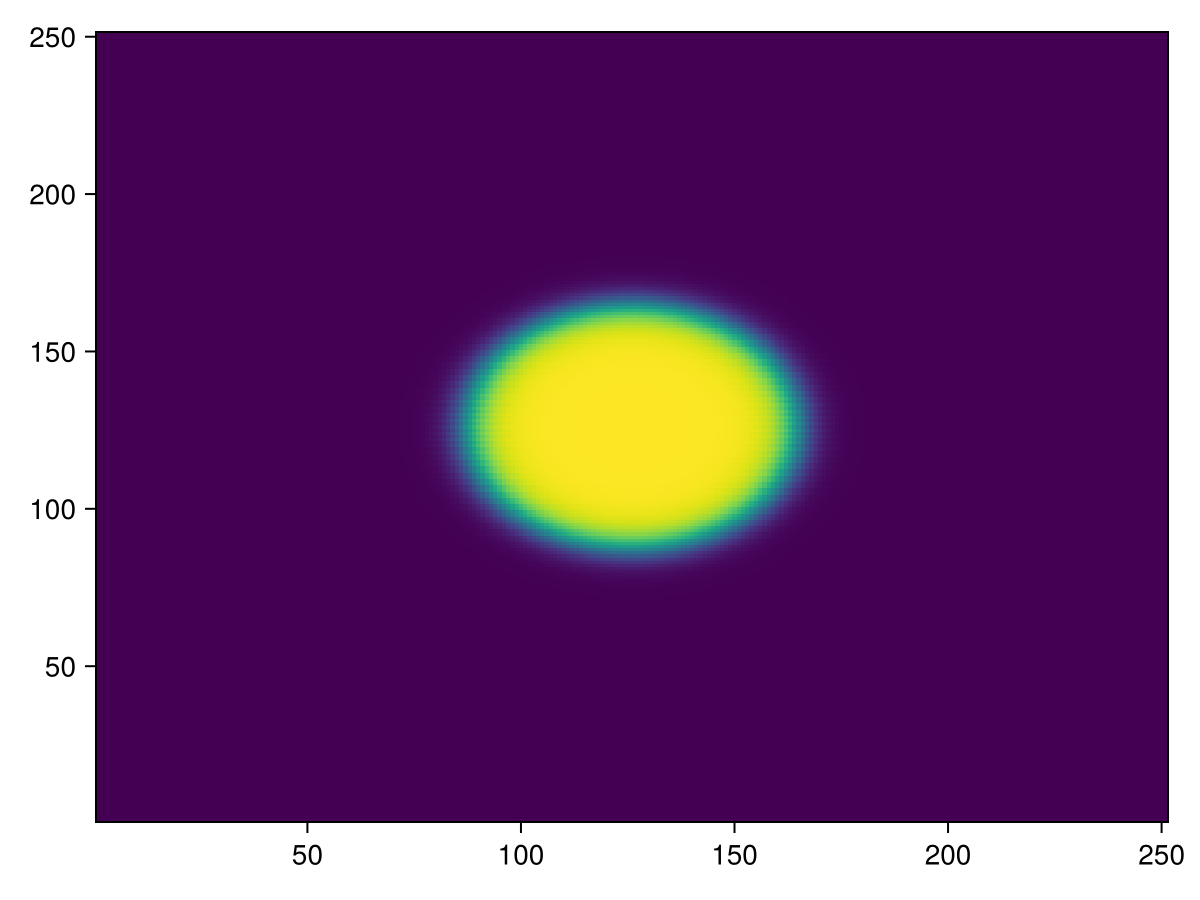

In [14]:
show_heatmap(logistic_solution(tₑ).C)

Generate the Gompertz simulation

In [15]:
gompertz_sim = evalsim(gompertz_proliferation_invasion)
gₘ = gompertz_sim(dualmesh, default_dec_generate, DiagonalHodge())

(::Decapodes.var"#f#82"{PreallocationTools.FixedSizeDiffCache{Vector{Float64}, Vector{ForwardDiff.Dual{nothing, Float64, 12}}}, PreallocationTools.FixedSizeDiffCache{Vector{Float64}, Vector{ForwardDiff.Dual{nothing, Float64, 12}}}, PreallocationTools.FixedSizeDiffCache{Vector{Float64}, Vector{ForwardDiff.Dual{nothing, Float64, 12}}}, PreallocationTools.FixedSizeDiffCache{Vector{Float64}, Vector{ForwardDiff.Dual{nothing, Float64, 12}}}, PreallocationTools.FixedSizeDiffCache{Vector{Float64}, Vector{ForwardDiff.Dual{nothing, Float64, 12}}}, PreallocationTools.FixedSizeDiffCache{Vector{Float64}, Vector{ForwardDiff.Dual{nothing, Float64, 12}}}, PreallocationTools.FixedSizeDiffCache{Vector{Float64}, Vector{ForwardDiff.Dual{nothing, Float64, 12}}}, SparseArrays.SparseMatrixCSC{Float64, Int32}, Decapodes.var"#5#10"{Decapodes.var"#3#8"}}) (generic function with 1 method)

Execute the Gompertz simulation

In [16]:
problem = ODEProblem(gₘ, u₀, (0, tₑ), constants_and_parameters)
gompertz_solution = solve(problem, Tsit5());

Let's examine this solution now.

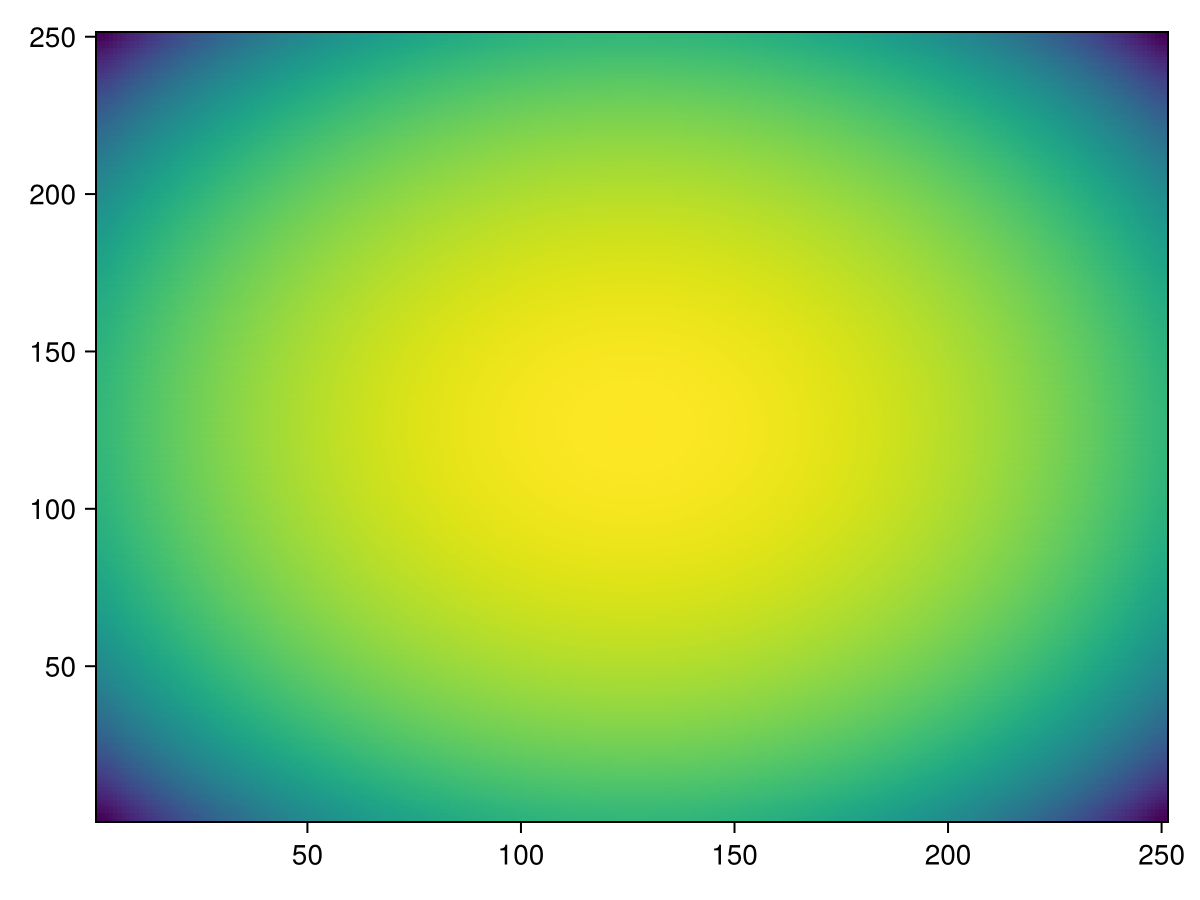

In [17]:
show_heatmap(gompertz_solution(tₑ).C)